In [60]:
import pandas as pd

df = pd.read_csv('bank.csv')
X = df.drop('deposit', axis=1)
y = df['deposit'].map({'yes': 1, 'no': 0})

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(random_state=42, class_weight='balanced')) 
])
model

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.82      0.85      0.84      2942
           1       0.83      0.79      0.81      2639

    accuracy                           0.82      5581
   macro avg       0.82      0.82      0.82      5581
weighted avg       0.82      0.82      0.82      5581



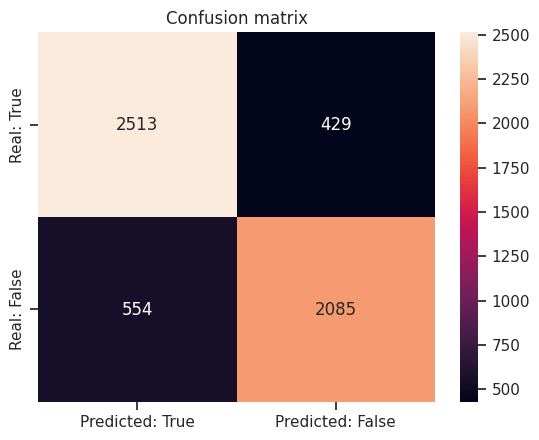

In [62]:
import seaborn as sns
sns.set_theme(style='ticks')

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='')
ax.set_title("Confusion matrix")
ax.set_yticks([0.5, 1.5], ['Real: True', 'Real: False'])
ax.set_xticks([0.5, 1.5], ['Predicted: True', 'Predicted: False'])
plt.show()

In [64]:
for threshold in [0.1, 0.25, 0.5, 0.75, 0.9]:
    logits = model.predict_proba(X_test)
    y_pred = logits[:, 1] > threshold
    print(f"Threshold {threshold:.2f} accuracy: {accuracy_score(y_pred, y_test):.2%}")

Threshold 0.10 accuracy: 65.47%
Threshold 0.25 accuracy: 79.90%
Threshold 0.50 accuracy: 82.39%
Threshold 0.75 accuracy: 75.88%
Threshold 0.90 accuracy: 67.71%


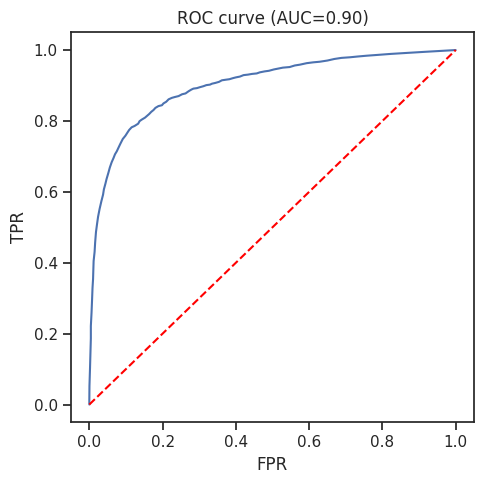

In [ ]:
import numpy as np

logits = model.predict_proba(X_test)
    
@np.vectorize
def roc(t: float):
    y_pred = logits[:, 1] > t
    cm = confusion_matrix(y_test, y_pred)
    tpr = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    fpr = 1 - cm[1, 1] / (cm[1, 1] + cm[1, 0])
    return fpr, tpr

def auc(x, y):
    return np.sum(0.5 * (y[:-1] + y[1:]) * (x[1:] - x[:-1]))

thresholds = np.linspace(0, 1, 101)
x, y = roc(thresholds)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x, y)
ax.plot([0, 1], [0, 1], c='red', ls='--')
ax.set_title(f"ROC curve (AUC={auc(x, y):.2f})")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
fig.tight_layout()

In [89]:
@np.vectorize
def cost(t):
    y_pred = logits[:, 1] > t
    cm = confusion_matrix(y_test, y_pred)
    return 10 * cm[1, 0] + 3 * cm[0, 1]

t = np.linspace(0, 1, 101)
idx = np.argmin(cost(t))
print(f"Optimal threshold: {t[idx]:.2f}")

Optimal threshold: 0.25
